<a href="https://colab.research.google.com/github/letrongminh/Torch4GANs/blob/main/LSTM04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparing Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd

N = 20
time_ser = pd.Series(np.arange(N), index=pd.period_range(start='2010', freq='A', periods=N, name='Year'),dtype=pd.Int8Dtype)
time_ser.head()

Year
2010    0
2011    1
2012    2
2013    3
2014    4
Freq: A-DEC, dtype: object

In [3]:
from pandas import DataFrame, concat

In [4]:
#temps = DataFrame(time_ser.values)
dt_frame_X = concat([time_ser.shift(2), 
                   time_ser.shift(3), 
                   time_ser.shift(4), 
                   time_ser.shift(5), 
                   time_ser.shift(6)], axis=1)

In [5]:
dt_frame_X

,0,1,2,3,4
Year,,,,,
2010,NaN,NaN,NaN,NaN,NaN
2011,NaN,NaN,NaN,NaN,NaN
2012,0,NaN,NaN,NaN,NaN
2013,1,0,NaN,NaN,NaN
2014,2,1,0,NaN,NaN
2015,3,2,1,0,NaN
2016,4,3,2,1,0
2017,5,4,3,2,1
2018,6,5,4,3,2


In [6]:
dt_frame_y = concat([time_ser.shift(-2), 
                     time_ser.shift(-1), 
                     time_ser.shift(0)], axis=1)
dt_frame_y.head()

,0,1,2
Year,,,
2010,2,1,0
2011,3,2,1
2012,4,3,2
2013,5,4,3
2014,6,5,4


In [7]:
data = concat({'Target':dt_frame_y, 'Feature':dt_frame_X}, axis = 1)

In [8]:
data.head(10)

Target        Feature                    
          0   1  2       0    1    2    3    4
Year                                          
2010      2   1  0     NaN  NaN  NaN  NaN  NaN
2011      3   2  1     NaN  NaN  NaN  NaN  NaN
2012      4   3  2       0  NaN  NaN  NaN  NaN
2013      5   4  3       1    0  NaN  NaN  NaN
2014      6   5  4       2    1    0  NaN  NaN
2015      7   6  5       3    2    1    0  NaN
2016      8   7  6       4    3    2    1    0
2017      9   8  7       5    4    3    2    1
2018     10   9  8       6    5    4    3    2
2019     11  10  9       7    6    5    4    3

# Multistep Forecasting Strategies

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime

In [10]:
# Into datetime format
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

org_col_names=["No", "year","month", "day", "hour", "pm2.5", "DEWP","TEMP", "PRES", "cbwd", "Iws", "Is", "Ir"]
col_names = ['pollution', 'dew', 'temp', 'pressure', 'w_dir', 'w_speed', 'snow', 'rain']

dataset = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks_1/PyTorchtoGANs/LSTM/AirPollution.csv', index_col=0,
                      date_parser = parse,
                      parse_dates = [["year","month", "day", "hour"]])

In [11]:
dataset                          

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,43820,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,43821,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,43822,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [12]:
### Data clean
dataset.drop('No', axis=1, inplace=True)
dataset.columns = col_names
dataset

,pollution,dew,temp,pressure,w_dir,w_speed,snow,rain
year_month_day_hour,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [13]:
dataset['pollution'].fillna(0, inplace = True)
print(dataset.shape)
dataset = dataset[24:] # drop first day
dataset.to_csv('pollution.csv')
print(dataset.shape)
dataset.head()

(43824, 8)
(43800, 8)


,pollution,dew,temp,pressure,w_dir,w_speed,snow,rain
year_month_day_hour,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [14]:
# load dataset
df = pd.read_csv('pollution.csv', header=0, index_col=0)
df.describe()

,pollution,dew,temp,pressure,w_speed,snow,rain
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,94.013516,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023
std,92.252276,14.429326,12.193384,10.271411,50.022729,0.760582,1.416247
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,24.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,68.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,132.250000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


['pollution', 'dew', 'temp', 'pressure', 'w_dir', 'w_speed', 'snow', 'rain']


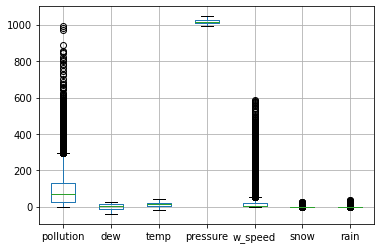

In [15]:
dataset_columns = df.columns.tolist()
print(dataset_columns)

#Box plot
#pd.options.display.mpl_style = False
df.boxplot()

Analysing relationship between different features


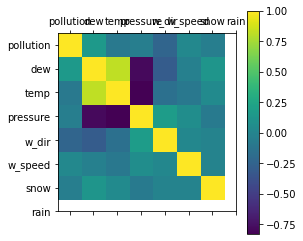

In [16]:
correct_cols = dataset_columns
#plt.figure(1, figsize = 10)
plt.matshow(df.corr())
plt.xticks(range(len(correct_cols)), correct_cols)
plt.yticks(range(len(correct_cols)), correct_cols)
plt.colorbar()
plt.show()

In [17]:
df.values[:, 4]

array(['SE', 'SE', 'SE', ..., 'NW', 'NW', 'NW'], dtype=object)

In [18]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

values = df.values
encoder = LabelEncoder()
values[:, 4] = encoder.fit_transform(values[:, 4])
values = values.astype('float32')
values

array([[129.  , -16.  ,  -4.  , ...,   1.79,   0.  ,   0.  ],
       [148.  , -15.  ,  -4.  , ...,   2.68,   0.  ,   0.  ],
       [159.  , -11.  ,  -5.  , ...,   3.57,   0.  ,   0.  ],
       ...,
       [ 10.  , -22.  ,  -3.  , ..., 242.7 ,   0.  ,   0.  ],
       [  8.  , -22.  ,  -4.  , ..., 246.72,   0.  ,   0.  ],
       [ 12.  , -21.  ,  -3.  , ..., 249.85,   0.  ,   0.  ]],
      dtype=float32)

In [19]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(values)


In [20]:
scaled_dataset

array([[0.12977867, 0.35294122, 0.24590163, ..., 0.00229001, 0.        ,
        0.        ],
       [0.14889336, 0.36764708, 0.24590163, ..., 0.00381099, 0.        ,
        0.        ],
       [0.15995975, 0.4264706 , 0.22950819, ..., 0.00533197, 0.        ,
        0.        ],
       ...,
       [0.01006036, 0.2647059 , 0.26229507, ..., 0.41399646, 0.        ,
        0.        ],
       [0.00804829, 0.2647059 , 0.24590163, ..., 0.4208665 , 0.        ,
        0.        ],
       [0.01207243, 0.2794118 , 0.26229507, ..., 0.42621556, 0.        ,
        0.        ]], dtype=float32)

In [21]:
#### creating windows shift data
def to_train_target(data):
  window_size = 4
  X = []
  y = []
  for i in range(window_size, len(data)): ### from 4 -> len(data)
    X.append(data[i-window_size:i, :])
    y.append(data[i, 0:1])

  return X, y

In [22]:
X, y = to_train_target(scaled_dataset)
X = np.array(X)
y = np.array(y)

print('y: ', y.shape)
print('X: ', X.shape) 

y:  (43796, 1)
X:  (43796, 4, 8)


In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2) 

In [24]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(35036, 4, 8) (8760, 4, 8) (35036, 1) (8760, 1)


In [25]:
print(X_train.shape[1], X_train.shape[2])

4 8


In [26]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

initial_learning_rate = 0.01
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

In [27]:
#### LSTM Build

model = Sequential()
model.add(LSTM(64, activation='silu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True, activation='silu'))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='silu'))
model.add(Dense(1))
model.compile(optimizer=opt, loss = 'mean_squared_error',)

In [28]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=0,
                                              patience=10, mode="auto", 
                                              baseline=None, restore_best_weights=True,)

model.fit(X_train, y_train, epochs = 100, batch_size = 32, 
          callbacks=early_stop)

Epoch 1/100
1095/1095 [==============================] - 12s 8ms/step - loss: 0.0030
Epoch 2/100
1095/1095 [==============================] - 9s 8ms/step - loss: 0.0017
Epoch 3/100
1095/1095 [==============================] - 8s 8ms/step - loss: 0.0011
Epoch 4/100
1095/1095 [==============================] - 9s 8ms/step - loss: 9.7425e-04
Epoch 5/100
1095/1095 [==============================] - 9s 8ms/step - loss: 9.1116e-04
Epoch 6/100
1095/1095 [==============================] - 9s 8ms/step - loss: 8.7051e-04
Epoch 7/100
1095/1095 [==============================] - 9s 8ms/step - loss: 8.5045e-04
Epoch 8/100
1095/1095 [==============================] - 9s 8ms/step - loss: 8.4085e-04
Epoch 9/100
1095/1095 [==============================] - 9s 8ms/step - loss: 8.2075e-04
Epoch 10/100
1095/1095 [==============================] - 9s 8ms/step - loss: 8.1592e-04
Epoch 11/100
1095/1095 [==============================] - 8s 8ms/step - loss: 8.1221e-04
Epoch 12/100
1095/1095 [=================

In [30]:
from keras.models import load_model
model.save('/content/drive/MyDrive/Colab_Notebooks_1/PyTorchtoGANs/LSTM/Air_Pollution_Multivariate.h5')

In [31]:
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error
ms_err = mean_squared_error(y_test, y_pred)

rmserr = np.sqrt(ms_err)
rmserr

0.025622306

In [33]:
#Y_predicted = scaler.inverse_transform(Y_pred)
print('y_predicted:',y_pred.shape)
#print('X_train' ,X_train.shape)
print('X_test:' ,X_test.shape)
print('scaled Values shap:e', scaled_dataset.shape)


y_predicted: (8760, 1)
X_test: (8760, 4, 8)
scaled Values shap:e (43800, 8)


In [34]:

#Scaling back to the original scale
d = scaled_dataset[:8760,:]
print('dummy',d.shape)
print('Y_pred',y_pred.shape)
y_predicted = np.concatenate((y_pred,d[:8760,1:]), axis =1)
print('concat y_pred',y_pred.shape)
y_tested = np.concatenate((y_test, d[:8760,1:]), axis = 1)
print('concat Y_test', y_test.shape)

dummy (8760, 8)
Y_pred (8760, 1)
concat y_pred (8760, 1)
concat Y_test (8760, 1)


In [35]:
y_predicted = scaler.inverse_transform(y_predicted)
y_tested = scaler.inverse_transform(y_tested)
y_predicted = y_predicted[:,0:1]
y_tested = y_tested[:,0:1]
print('Y_tested', y_tested.shape)
print('Y_predicted', y_predicted.shape)

Y_tested (8760, 1)
Y_predicted (8760, 1)


In [36]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_tested, y_predicted)

rms_err_real_data = np.sqrt(mse)
rms_err_real_data

25.468573

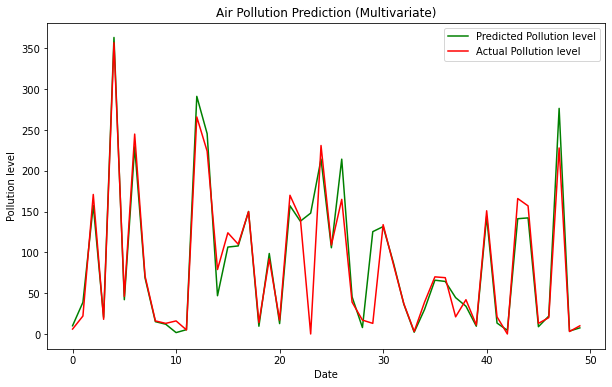

<Figure size 432x288 with 0 Axes>

In [38]:
#Plot the graph between actual vs predicted values
plt.figure(figsize=(10,6))  
plt.plot(y_predicted[:50,:], color= 'green',label = 'Predicted Pollution level')
plt.plot(y_tested[:50,:] , color = 'red',label = 'Actual Pollution level')
plt.title("Air Pollution Prediction (Multivariate)")
plt.xlabel("Date")
plt.ylabel("Pollution level")
plt.legend()
plt.show()
plt.savefig('graph.png')